In [75]:
# This model is based on [MuradAhmed00] model, selected as the best approach with feature engineering and hyper tuning in comparison with [nadeli11] baseline model
# 📦 Imports
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import randint, uniform

import joblib

# 🔍 Auto-detect PROJECT_ROOT as the first parent that contains 'Data' and 'Models'
current = Path.cwd()
while not (current / "Data").exists() or not (current / "Models").exists():
    current = current.parent
PROJECT_ROOT = current

# 📁 Define key paths
RAW_DATA_PATH = PROJECT_ROOT / "Data" / "Raw" / "Sample_Superstore.csv"
FEATURE_ENGINEERED_PATH = PROJECT_ROOT / "Data" / "Processed" / "feature_engineered_superstore.csv"
EX_MODEL_OUTPUT_DIR = PROJECT_ROOT / "Experiments"
EX_METRIC_LOG_PATH = PROJECT_ROOT / "Experiments" / "experements_model_metrics_log.csv"

# 📁 Ensure output directory exists
EX_MODEL_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

In [76]:
# Load dataset
file_path = PROJECT_ROOT / "Data" / "Raw" / "Sample_superstore.csv"

df = pd.read_csv(file_path , encoding='latin1', parse_dates=['Order Date', 'Ship Date'])

# Engineer features (same as original teammate notebook)
df['Order_Month'] = df['Order Date'].dt.month
df['Month_sin'] = np.sin(2*np.pi*(df['Order_Month']-1)/12)
df['Month_cos'] = np.cos(2*np.pi*(df['Order_Month']-1)/12)
df['Order_Weekday'] = df['Order Date'].dt.weekday
df['Weekday_sin'] = np.sin(2*np.pi*df['Order_Weekday']/7)
df['Weekday_cos'] = np.cos(2*np.pi*df['Order_Weekday']/7)
df['Ship_Delay'] = (df['Ship Date'] - df['Order Date']).dt.days
df['Bulk_Flag'] = (df['Quantity'] > df['Quantity'].quantile(0.75)).astype(int)
df['Log_Quantity'] = np.log1p(df['Quantity'])
df['Quantity_Sq'] = df['Quantity']**2
df['Discount_to_Qty'] = df['Discount'] / (df['Quantity'] + 1e-6)
df['Profit_per_Unit'] = df['Profit'] / (df['Quantity'] + 1e-6)
df['Cat_Mean_Qty'] = df.groupby('Category')['Quantity'].transform('mean')
df['Cat_STD_Qty'] = df.groupby('Category')['Quantity'].transform('std').fillna(0)
df['Subcat_Mean_Discount'] = df.groupby('Sub-Category')['Discount'].transform('mean')
df['Subcat_STD_Discount'] = df.groupby('Sub-Category')['Discount'].transform('std').fillna(0)
df = df.sort_values(['Customer ID', 'Order Date'])
df['Prev_Order_Date'] = df.groupby('Customer ID')['Order Date'].shift(1)
df['Days_Since_Last_Order'] = (df['Order Date'] - df['Prev_Order_Date']).dt.days.fillna(-1)
df['Cust_Order_Count'] = df.groupby('Customer ID')['Order ID'].transform('nunique')
df['Cust_Mean_Qty'] = df.groupby('Customer ID')['Quantity'].transform('mean')
df['Items_per_Order'] = df.groupby('Order ID')['Quantity'].transform('sum')
df['Unique_Products'] = df.groupby('Order ID')['Sub-Category'].transform('nunique')

# Features
cats = ['Category', 'Sub-Category', 'Region', 'Segment', 'Ship Mode']
nums = ['Quantity', 'Discount', 'Profit']
eng  = ['Month_sin','Month_cos','Weekday_sin','Weekday_cos','Ship_Delay',
        'Bulk_Flag','Log_Quantity','Quantity_Sq','Discount_to_Qty','Profit_per_Unit',
        'Cat_Mean_Qty','Cat_STD_Qty','Subcat_Mean_Discount','Subcat_STD_Discount',
        'Days_Since_Last_Order','Cust_Order_Count','Cust_Mean_Qty',
        'Items_per_Order','Unique_Products']
features = cats + nums + eng
target = 'Sales'

# Prepare inputs
df = df.dropna(subset=features + [target])
tm_X = df[features]
tm_Y = df[target]

# Split
tm_X_train, tm_X_test, tm_y_train, tm_y_test = train_test_split(tm_X, tm_Y, test_size=0.2, random_state=42)

# Pipeline
preprocessor = ColumnTransformer([('ohe', OneHotEncoder(handle_unknown='ignore'), cats)], remainder='passthrough')
tm_rf_pipe = Pipeline([
    ('prep', preprocessor),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
])

# Random Search
tm_param_dist = {
    'model__n_estimators': randint(100, 500),
    'model__max_depth': randint(5, 20),
    'model__min_samples_leaf': randint(5, 50),
    'model__max_features': ['sqrt', 'log2', 0.3, 0.5, 0.7]
}
tm_model = RandomizedSearchCV(tm_rf_pipe, tm_param_dist, n_iter=30, cv=5, scoring='r2', random_state=42, n_jobs=-1, verbose=1)
tm_model.fit(tm_X_train, tm_y_train)

search = RandomizedSearchCV(
    tm_rf_pipe, tm_param_dist, n_iter=30, cv=5,
    scoring='r2', random_state=42, n_jobs=-1, verbose=1
)
search.fit(tm_X_train, tm_y_train)

tm_best = search.best_estimator_
print("Best hyperparameters:", search.best_params_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best hyperparameters: {'model__max_depth': 17, 'model__max_features': 0.7, 'model__min_samples_leaf': 5, 'model__n_estimators': 444}


In [77]:
print("✅ Teammate's Random Forest Model trained.")
print("Best Parameters:", tm_model.best_params_)

✅ Teammate's Random Forest Model trained.
Best Parameters: {'model__max_depth': 17, 'model__max_features': 0.7, 'model__min_samples_leaf': 5, 'model__n_estimators': 444}


In [78]:
# Evaluate teammate's best model
tm_train_pred = tm_best.predict(tm_X_train)
tm_test_pred  = tm_best.predict(tm_X_test)

# R² scores
tm_r2_train = r2_score(tm_y_train, tm_train_pred)
tm_r2_test  = r2_score(tm_y_test,  tm_test_pred)

# Adjusted R²
n_train, n_test = len(tm_y_train), len(tm_y_test)
p = len(features)
tm_adj_r2_train = 1 - (1 - tm_r2_train) * (n_train - 1) / (n_train - p - 1)
tm_adj_r2_test  = 1 - (1 - tm_r2_test)  * (n_test  - 1) / (n_test  - p - 1)

# 🧾 Print results
print("✅ Teammate model after tuning:")
print(f"  Train → RMSE: {root_mean_squared_error(tm_y_train, tm_train_pred):.2f}, "
      f"R²: {tm_r2_train:.4f}, Adjusted R²: {tm_adj_r2_train:.4f}")
print(f"  Test  → RMSE: {root_mean_squared_error(tm_y_test, tm_test_pred):.2f}, "
      f"R²: {tm_r2_test:.4f}, Adjusted R²: {tm_adj_r2_test:.4f}")

# MAPE – Mean Absolute Percentage Error
tm_mape_test = mean_absolute_percentage_error(tm_y_test, tm_test_pred) * 100
tm_mape_train = mean_absolute_percentage_error(tm_y_train, tm_train_pred) * 100
print(f"Test MAPE: {tm_mape_test:.2f}%")
print(f"Train MAPE: {tm_mape_train:.2f}%")

# SMAPE – Symmetric Mean Absolute Percentage Error
def tm_smape(y_true, y_pred, epsilon=1e-8):
    num = np.abs(y_pred - y_true)
    den = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(num / (den + epsilon)) * 100

tm_smape_train = tm_smape(tm_y_train, tm_train_pred)
tm_smape_test  = tm_smape(tm_y_test,  tm_test_pred)
print(f"Train SMAPE: {tm_smape_train:.2f}%")
print(f"Test  SMAPE: {tm_smape_test:.2f}%")

✅ Teammate model after tuning:
  Train → RMSE: 280.40, R²: 0.8044, Adjusted R²: 0.8037
  Test  → RMSE: 269.45, R²: 0.7828, Adjusted R²: 0.7798
Test MAPE: 48.88%
Train MAPE: 35.87%
Train SMAPE: 25.34%
Test  SMAPE: 31.68%


Features Importance:

Profit: 0.671
Profit_per_Unit: 0.175
Discount_to_Qty: 0.022
Discount: 0.015
Subcat_Mean_Discount: 0.011
Quantity_Sq: 0.008
Log_Quantity: 0.008
Cat_Mean_Qty: 0.008
Quantity: 0.007
Sub-Category_Machines: 0.007
Category_Office Supplies: 0.006
Cust_Order_Count: 0.006
Cust_Mean_Qty: 0.005
Items_per_Order: 0.004
Subcat_STD_Discount: 0.004
Sub-Category_Storage: 0.004
Sub-Category_Chairs: 0.003
Sub-Category_Copiers: 0.003
Month_sin: 0.002
Month_cos: 0.002


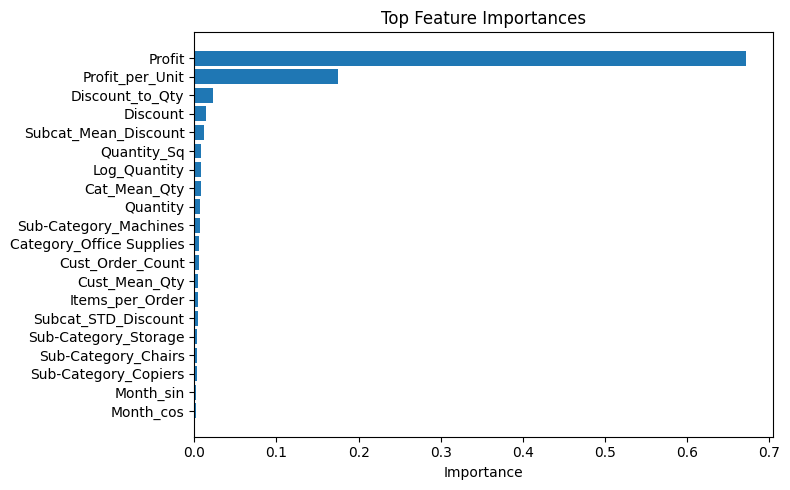

In [79]:
# Top Feature Importances

import pandas as pd
import matplotlib.pyplot as plt

# 1) Grab the best pipeline
best_pipe = search.best_estimator_

# 2) Determine feature names
if 'prep' in best_pipe.named_steps:
    feat_names = best_pipe.named_steps['prep'].get_feature_names_out()
    feat_names = [n.split("__",1)[1] for n in feat_names]
else:
    
    feat_names = [
        'Profit',
        'Profit_per_Unit',
        'Discount_to_Qty',
        'Discount',
        'Subcat_Mean_Discount'
    ]

# 3) importances
importances = best_pipe.named_steps['model'].feature_importances_

# 4) Build & sort DataFrame
imp_df = pd.DataFrame({
    'feature': feat_names,
    'importance': importances
}).sort_values('importance', ascending=False).head(20)

# 4) Print the Top 20 Most Important Features
top_n = 20
tm_top_feat = imp_df.head(top_n)
print("Features Importance:\n")
for i, row in tm_top_feat.iterrows():
    print(f"{row['feature']}: {row['importance']:.3f}")

# 5) Plot 
plt.figure(figsize=(8,5))
plt.barh(imp_df['feature'][::-1], imp_df['importance'][::-1])
plt.xlabel('Importance')
plt.title('Top Feature Importances')
plt.tight_layout()
plt.show()


In [80]:
# Additional evaluation metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
import numpy as np


mse = mean_squared_error(tm_y_test, test_pred)
rmse = np.sqrt(mse)
rmse_test = root_mean_squared_error(tm_y_test, test_pred)
mae_train = mean_absolute_error(tm_y_train, train_pred)
mae_test  = mean_absolute_error(tm_y_test, test_pred)
mape_train = mean_absolute_percentage_error(tm_y_train, train_pred)
mape_test  = mean_absolute_percentage_error(tm_y_test, test_pred)

# Print all metrics
print("\n🔍 Detailed Evaluation Metrics")
print(f"Train → R²: {r2_train:.4f}, Adjusted R²: {adj_r2_train:.4f}, RMSE: {rmse_train:.2f}, MAE: {mae_train:.2f}, MAPE: {mape_train:.2%}")
print(f"Test  → R²: {r2_test:.4f}, Adjusted R²: {adj_r2_test:.4f}, RMSE: {rmse_test:.2f}, MAE: {mae_test:.2f}, MAPE: {mape_test:.2%}")

# Optional: Log results to CSV
import csv
log_path = PROJECT_ROOT / "Experiments" / "model_comparison_log.csv"

tm_metrics = {
    "Model": "Teammate_RF",
    "Train_R2": r2_train,
    "Test_R2": r2_test,
    "Train_Adj_R2": adj_r2_train,
    "Test_Adj_R2": adj_r2_test,
    "Train_RMSE": rmse_train,
    "Test_RMSE": rmse_test,
    "Train_MAE": mae_train,
    "Test_MAE": mae_test,
    "Train_MAPE": mape_train,
    "Test_MAPE": mape_test,
    "Best_Params": str(search.best_params_)
}

# Save to file (append if exists, create header if not)
header = list(tm_metrics.keys())
write_header = not log_path.exists()

with open(log_path, mode='a', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=header)
    if write_header:
        writer.writeheader()
    writer.writerow(tm_metrics)

print(f"\n✅ Metrics logged to: {log_path}")

# Save prediction errors
tm_error_df = pd.DataFrame({
    "Actual_tm": tm_y_test,
    "Predicted_tm": tm_test_pred
})
tm_error_df.to_csv(Path.cwd().parent / "Models" / "Artifacts" / "top_tm_prediction_errors.csv", index=False)




🔍 Detailed Evaluation Metrics
Train → R²: 0.8044, Adjusted R²: 0.8037, RMSE: 280.40, MAE: 56.56, MAPE: 35.87%
Test  → R²: 0.7828, Adjusted R²: 0.7798, RMSE: 269.45, MAE: 75.16, MAPE: 48.88%

✅ Metrics logged to: /Users/nastaran/DSI_Project/C6_ML5/Experiments/model_comparison_log.csv


In [81]:
! pip install tabulate

In [83]:
import pandas as pd
from pathlib import Path

# 📁 Setup output path
experiments_dir = Path.cwd().parent / "Experiments"
experiments_dir.mkdir(exist_ok=True)
output_file = experiments_dir / "tm_rf_model_metrics.csv"

# Convert metrics to DataFrame
tm_metrics_df = pd.DataFrame([tm_metrics])

# Append or create
if output_file.exists():
    tm_metrics_df.to_csv(output_file, mode='a', header=False, index=False)
else:
    tm_metrics_df.to_csv(output_file, index=False)

# 📝 Print as Markdown
markdown = tm_metrics_df.to_markdown(index=False)
print(markdown)


| Model       |   Train_R2 |   Test_R2 |   Train_Adj_R2 |   Test_Adj_R2 |   Train_RMSE |   Test_RMSE |   Train_MAE |   Test_MAE |   Train_MAPE |   Test_MAPE | Best_Params                                                                                                    |
|:------------|-----------:|----------:|---------------:|--------------:|-------------:|------------:|------------:|-----------:|-------------:|------------:|:---------------------------------------------------------------------------------------------------------------|
| Teammate_RF |   0.804391 |  0.782779 |       0.803728 |      0.779803 |      280.396 |     269.452 |     56.5594 |    75.1619 |     0.358675 |    0.488784 | {'model__max_depth': 17, 'model__max_features': 0.7, 'model__min_samples_leaf': 5, 'model__n_estimators': 444} |
